# Import libraries


In [99]:
!pip install nltk
!pip install wordcloud

In [129]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline

stop_words = set(stopwords.words('english'))

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# import data

In [101]:

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [132]:
train_data_path = "drive/MyDrive/yassine_test/deeptweets/train.csv"
test_data_path = "drive/MyDrive/yassine_test/deeptweets/test.csv"
sample_sub_path = "drive/MyDrive/yassine_test/deeptweets/sample_submission.csv"

In [142]:
labels_map = {"Politics": 0, "Sports": 1}
labels_map_reverse = {0: "Politics", 1: "Sports"}

In [114]:
def import_data(file_path):
  df = pd.read_csv(file_path)
  return df


def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = text.replace("&", "")
    text = re.sub(r'\n', ' ', text)
    # text = re.sub(r'\bamp\b|\brt\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text


def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return " ".join(filtered_text)


def lemmatize_text(text):
    word_tokens = word_tokenize(text) # Tokenizing the text
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens] # Lemmatizing
    return " ".join(lemmatized_text) # Joining the words back into a string



def plot_wordcloud(train_df, column='cleaned_text'):
  # Concatenate all tweets with label 'politics'
  politics_text = ' '.join(train_df[train_df['Label'] == train_df.Label.unique()[0]][column])

  # Concatenate all tweets with label 'sport'
  sport_text = ' '.join(train_df[train_df['Label'] == train_df.Label.unique()[1]][column])

  # Generate a word cloud image for politics
  wordcloud_politics = WordCloud(background_color="white", max_words=100).generate(politics_text)

  # Generate a word cloud image for sport
  wordcloud_sport = WordCloud(background_color="white", max_words=100).generate(sport_text)

  # Display the generated image using matplotlib for politics
  plt.imshow(wordcloud_politics, interpolation='bilinear')
  plt.axis("off")
  plt.title('Politics Tweets Word Cloud')
  plt.show()

  # Display the generated image using matplotlib for sport
  plt.imshow(wordcloud_sport, interpolation='bilinear')
  plt.axis("off")
  plt.title('Sport Tweets Word Cloud')
  plt.show()


def plot_labels_dist(train_df):
  sns.countplot(x=train_df['Label'])
  plt.show()


def map_labels(train_df):
  train_df.Label = train_df.Label.map(labels_map).astype(int)
  return train_df

In [115]:
# import data
train_df = import_data(train_data_path)
test_df = import_data(test_data_path)

In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


0 null values


## convert sport politics to binary

In [117]:
train_df = map_labels(train_df)

In [120]:
# Apply the clean_text function to every tweet
train_df['cleaned_text'] = train_df['TweetText'].apply(clean_text)
# Apply the remove_stopwords function to every tweet
train_df['cleaned_text'] = train_df['cleaned_text'].apply(remove_stopwords)

In [121]:
train_df

,TweetId,Label,TweetText,cleaned_text
0,304271250237304833,0,'#SecKerry: The value of the @StateDept and @U...,value measured dollars terms deepest american ...
1,304834304222064640,0,'@rraina1481 I fear so',fear
2,303568995880144898,1,'Watch video highlights of the #wwc13 final be...,watch video highlights final australia west in...
3,304366580664528896,1,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,nitro circus
4,296770931098009601,1,'@cricketfox Always a good thing. Thanks for t...,always good thing thanks feedback
...,...,...,...,...
6520,296675082267410433,0,'Photo: PM has laid a wreath at Martyrs Monume...,photo pm laid wreath martyrs monument algiers
6521,306677536195231746,1,'The secret of the Chennai pitch - crumbling o...,secret chennai pitch crumbling edges solid mid...
6522,306451295307431937,1,@alinabhutto he isn't on Twitter either,isnt twitter either
6523,306088574221176832,1,'Which England player would you take out to di...,england player would take dinner featuring


lemmatize text

In [123]:
# Apply the lemmatize_text function to every tweet*
train_df['cleaned_text'] = train_df['cleaned_text'].apply(lemmatize_text)

In [126]:
train_df

,TweetId,Label,TweetText,cleaned_text
0,304271250237304833,0,'#SecKerry: The value of the @StateDept and @U...,value measured dollar term deepest american value
1,304834304222064640,0,'@rraina1481 I fear so',fear
2,303568995880144898,1,'Watch video highlights of the #wwc13 final be...,watch video highlight final australia west indie
3,304366580664528896,1,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,nitro circus
4,296770931098009601,1,'@cricketfox Always a good thing. Thanks for t...,always good thing thanks feedback
...,...,...,...,...
6520,296675082267410433,0,'Photo: PM has laid a wreath at Martyrs Monume...,photo pm laid wreath martyr monument algiers
6521,306677536195231746,1,'The secret of the Chennai pitch - crumbling o...,secret chennai pitch crumbling edge solid midd...
6522,306451295307431937,1,@alinabhutto he isn't on Twitter either,isnt twitter either
6523,306088574221176832,1,'Which England player would you take out to di...,england player would take dinner featuring


# EDA

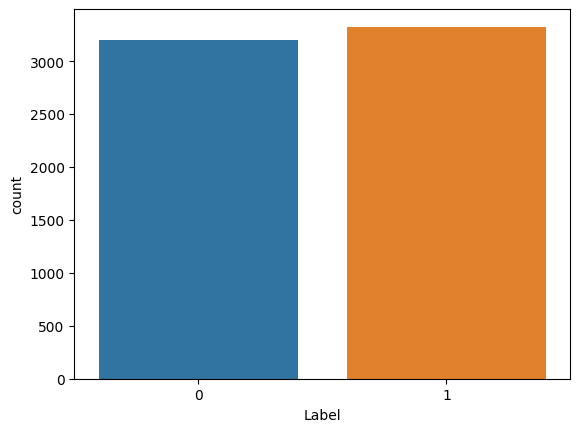

In [128]:
plot_labels_dist(train_df)

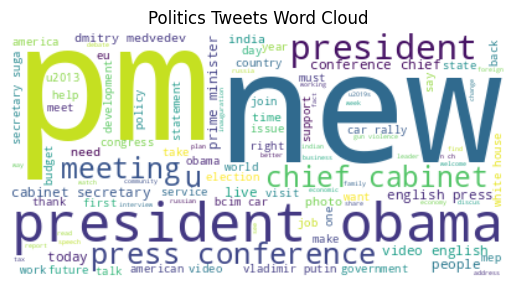

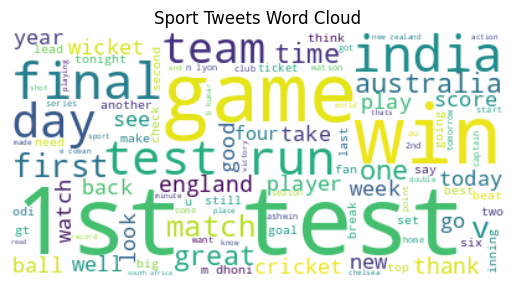

In [127]:
plot_wordcloud(train_df, 'cleaned_text')

remove amp, rt

# Predictive modelling

In [72]:
tfidf_data = train_df.copy()

In [82]:


# Define features and labels
X = tfidf_data['cleaned_text'].astype(str)
Y = tfidf_data['Label'].astype(float)

# Split train and test data
x_train, x_test, y_train, y_test = \
train_test_split(X, Y, test_size=0.3, random_state= 1)

In [80]:
#SVC()
pipeline_svc = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC(probability=True, kernel='rbf')),
])

#XGBoost()
pipeline_xgboost = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', XGBClassifier()),
])

#LogisticRegression()
pipeline_logistic = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression()),
])

In [83]:


# Test the logistic regression model on test data
pipeline_logistic.fit(x_train,y_train)
test_predictions_1 = pipeline_logistic.predict(x_test)
# Compute accuracy on test data
print("LogisticRegression Accuracy : %.5f" % accuracy_score(y_test , test_predictions_1))

# Test the xgboost model on test data
pipeline_xgboost.fit(x_train,y_train)
test_predictions_2 = pipeline_xgboost.predict(x_test)
# Compute accuracy on test data
print("XGBClassifier Accuracy : %.5f" % accuracy_score(y_test , test_predictions_2))

# Test the svm classifier model on test data
pipeline_svc.fit(x_train,y_train)
test_predictions_3 = pipeline_svc.predict(x_test)
# Compute accuracy on test data
print("SVC Accuracy : %.5f" % accuracy_score(y_test , test_predictions_3))




LogisticRegression Accuracy : 0.92237
XGBClassifier Accuracy : 0.87130
SVC Accuracy : 0.93003


# Test the model

In [130]:
test_df

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...
...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin..."
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR..."


In [136]:
# Apply the clean_text function to every tweet
test_df['cleaned_text'] = test_df['TweetText'].apply(clean_text)
# Apply the remove_stopwords function to every tweet
test_df['cleaned_text'] = test_df['cleaned_text'].apply(remove_stopwords)

In [137]:
test_df

,TweetId,TweetText,cleaned_text
0,306486520121012224,'28. The home side threaten again through Maso...,28 home side threaten mason bennett gets end l...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,thx asking see derives series abbreviations po...
2,289531046037438464,'@Sochi2014 construction along the shores of t...,construction along shores black sea
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,u2019s remarks meeting foreign minister wester...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,begun ricky ponting first player go hammer goe...
...,...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...,qualifier 1 eliminator games played chidambara...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin...",hi edward mission heres list 16 missions
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...,perera first purchase
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",thanks senator welcome charlottesville


In [133]:
sample_sub = import_data(sample_sub_path)

In [134]:
sample_sub

,TweetId,Label
0,13439423987429,Sports
1,48523497520948,Politics
2,183749287598,Sports
3,12749274958729,Sports


In [139]:
predictions = pipeline_svc.predict(test_df.cleaned_text.astype(str))

In [143]:
data_to_submit = pd.DataFrame({"tweetID": test_df.TweetId, "Label": predictions})
data_to_submit.Label = data_to_submit.Label.astype(int)

In [144]:
data_to_submit.Label = data_to_submit.Label.map(labels_map_reverse)

In [145]:
data_to_submit

,tweetID,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports
...,...,...
2605,282023761044189184,Sports
2606,303879735006601216,Sports
2607,297956846046703616,Sports
2608,304265049537658880,Sports


In [146]:
data_to_submit.to_csv("drive/MyDrive/yassine_test/deeptweets/data_to_submit.csv")